In [1]:
# This notebook was written with the help of ChatGPT (version GPT 5, October 2025), and checked by Lucie Perez

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

In [11]:
sns.set_theme(style="whitegrid", context="talk")  # good for papers
plt.rcParams["figure.dpi"] = 200

In [4]:
df = pd.read_csv("data/clause_number_results_assessment.csv")

In [12]:
#df

In [24]:
# 1) Order sizes for correct left→right plotting
size_order = ['small', 'medium', 'large']
df['size'] = pd.Categorical(df['size'], categories=size_order, ordered=True)

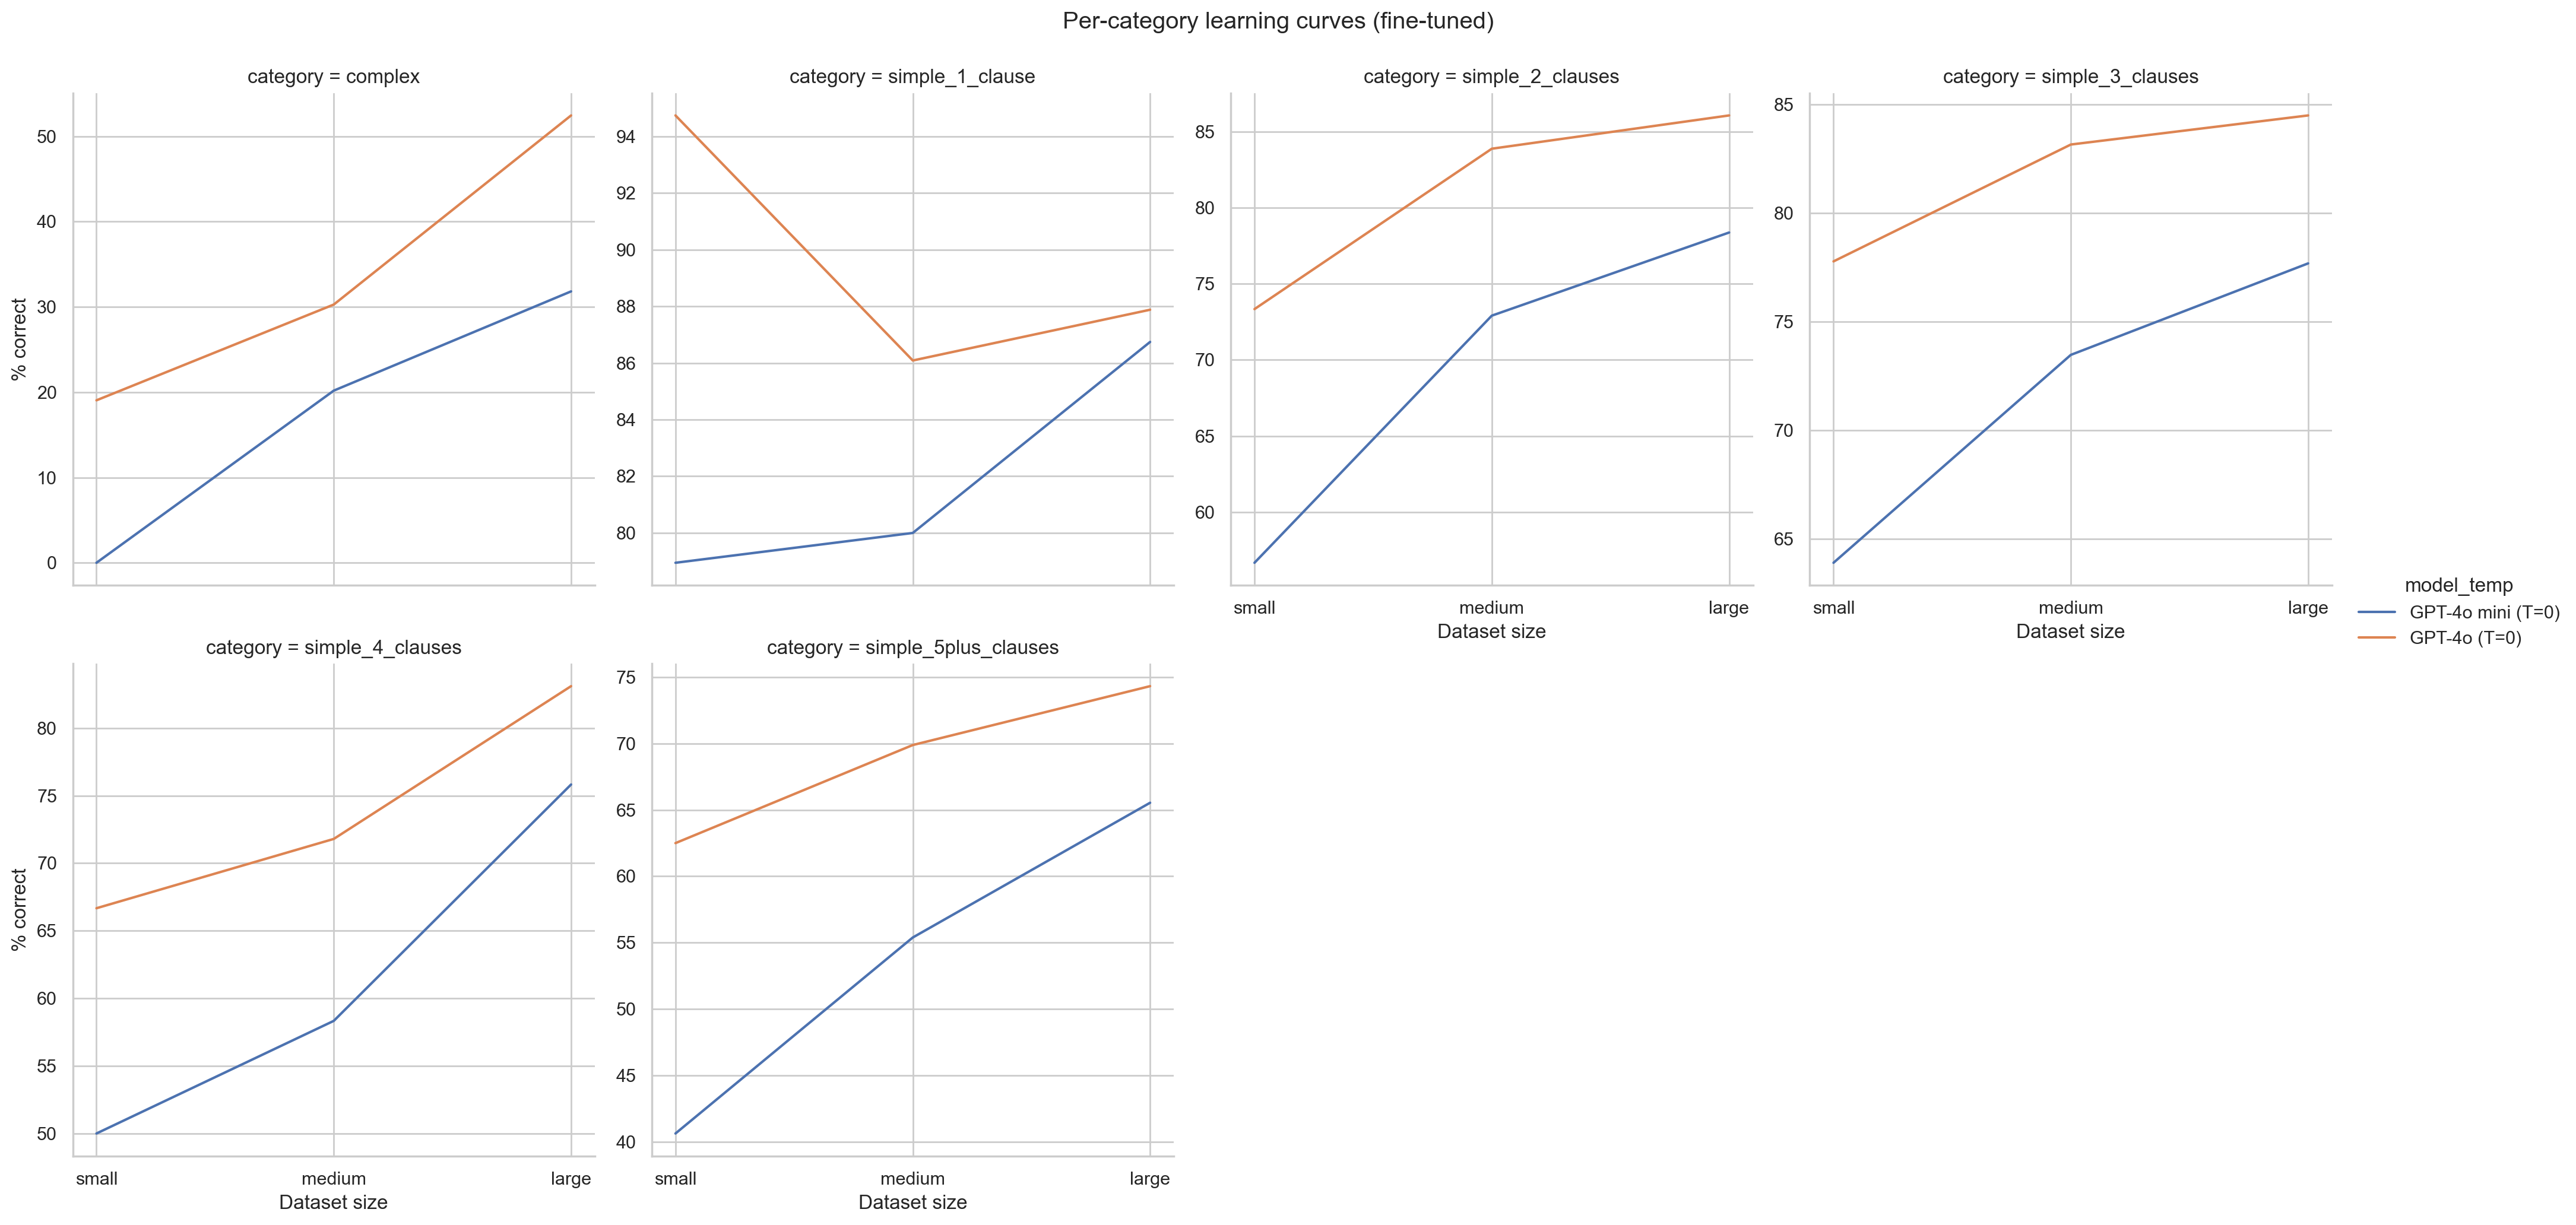

In [25]:
# 2) Per-category accuracy curves (fine-tuned models)
df_cat = df.copy()
df_cat['acc'] = (df_cat['True'] / (df_cat['True'] + df_cat['False'])) * 100

g = sns.relplot(
    data=df_cat[df_cat['status'] == 'fine-tuned'],
    x='size', y='acc',
    hue='model_temp',
    col='category', col_wrap=4,
    kind='line',
    markers=True, dashes=True,
    facet_kws={'sharey': False}
)
g.set_axis_labels('Dataset size', '% correct')
g.fig.suptitle('Per-category learning curves (fine-tuned)', y=1.03)
plt.show()

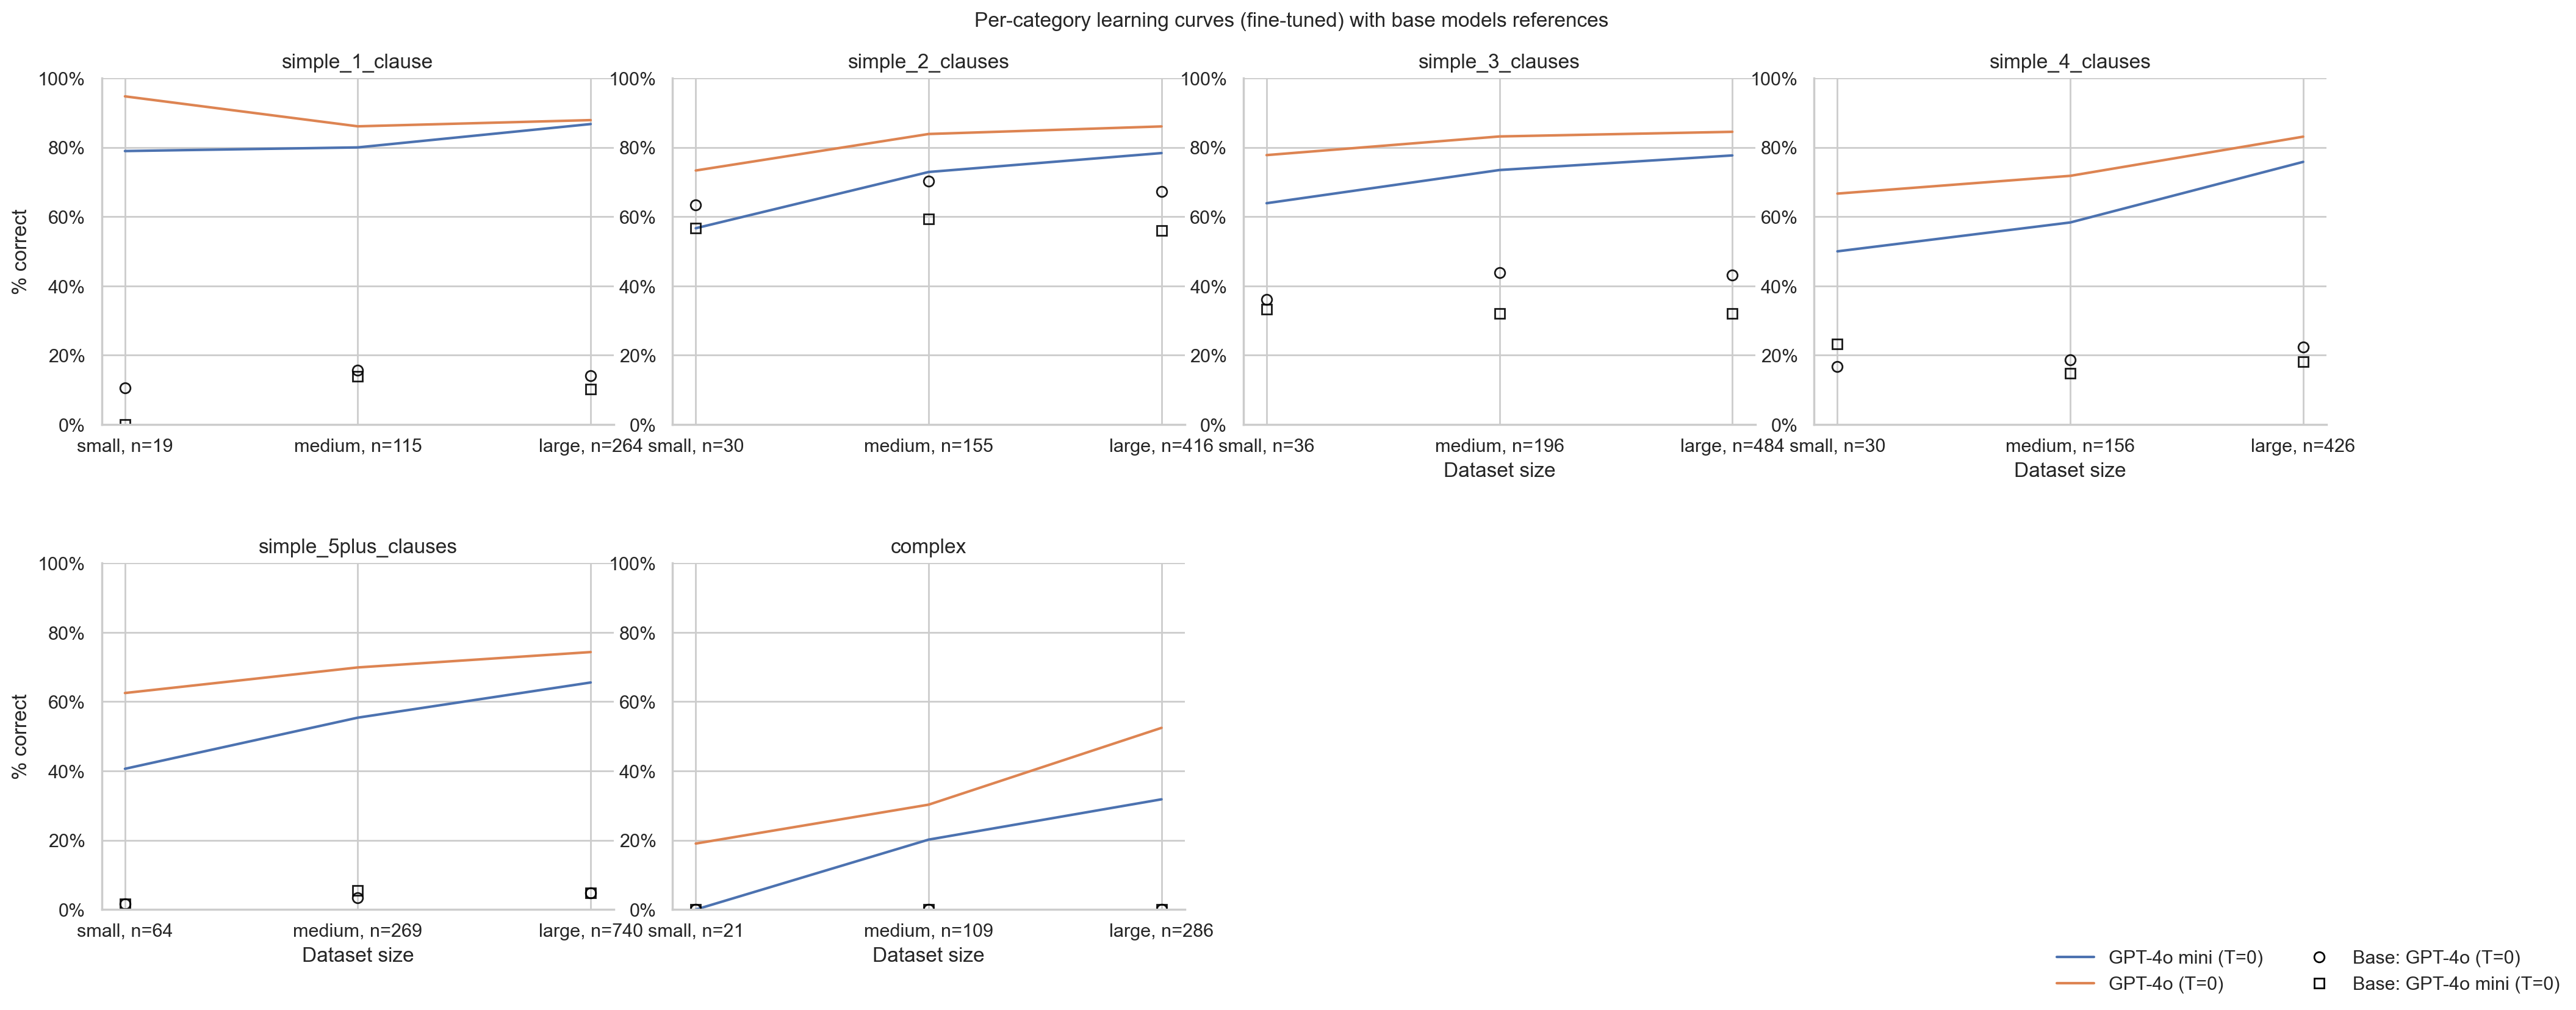

In [64]:
# 3) Per-category accuracy curves (fine-tuned models) with more details


# --- 0) Base setup
sns.set_theme(style="whitegrid")
size_order = ["small", "medium", "large"]

df_cat = df.copy()
df_cat["size"] = pd.Categorical(df_cat["size"], categories=size_order, ordered=True)
df_cat["acc"] = 100 * df_cat["True"] / (df_cat["True"] + df_cat["False"])
df_cat["n"]   = df_cat["True"] + df_cat["False"]

# One n per (category, size); avoid double-counting across models/status
n_map = (
    df_cat.groupby(["category", "size"], as_index=False)
          .agg(n=("n", "max"))
)
# Make a dict with string keys: (category, size_str) -> "size, n=XX"
n_label_map = {
    (row["category"], str(row["size"])): f'{row["size"]}, n={int(row["n"])}'
    for _, row in n_map.iterrows()
}

category_order = [
    "simple_1_clause",
    "simple_2_clauses",
    "simple_3_clauses",
    "simple_4_clauses",
    "simple_5plus_clauses",
    "complex"
]

# --- 1) Order facets by difficulty (fine-tuned accuracy at LARGE size, avg over models)
facet_order = (
    df_cat[(df_cat["status"] == "fine-tuned") & (df_cat["size"] == "large")]
    .groupby("category", as_index=False)["acc"].mean()
    .sort_values("acc")  # hardest (low acc) first
    ["category"].tolist()
)

# --- 2) Plot fine-tuned learning curves
g = sns.relplot(
    data=df_cat[df_cat["status"] == "fine-tuned"],
    x="size", y="acc",
    hue="model_temp",
    col="category", col_wrap=4,
    kind="line",
    markers=True, dashes=True,
    facet_kws={"sharey": False, "sharex": False},
    col_order=category_order,
    height=4, aspect=1.2
)
g.set_axis_labels("Dataset size", "% correct")
g.set_titles("{col_name}")
g.set(xlim=(-0.1, None), ylim=(0, 100))

# Format y axis as %
for ax in g.axes.ravel():
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.0f}%"))

# --- 3) Overlay BASE results as hollow markers (context, not curves)
base_points = (
    df_cat[df_cat["status"] == "base"]
    .groupby(["category", "model_temp", "size"], as_index=False)
    .agg(acc=("acc", "mean"))  # if base repeats per size/model/category, average
)

# assign a distinct marker per base model
model_order = sorted(df_cat['model_temp'].unique())
_markers = ['o','s','^','D','P','X','v','>','<','*']
marker_map = {m: _markers[i % len(_markers)] for i, m in enumerate(model_order)}

# Map each facet and add the base markers
axes_by_cat = {ax.get_title(): ax for ax in g.axes.ravel()}
for _, row in base_points.iterrows():
    cat = row["category"]
    if cat in axes_by_cat:
        ax = axes_by_cat[cat]

        # get true tick centers from the axis (more accurate than using index)
        ticks = ax.get_xticks()
        tick_map = dict(zip(size_order, ticks))
        x_center = tick_map.get(row["size"], size_order.index(row["size"]))
        x_pos = x_center

        ax.plot(
            x_pos, row["acc"],
            marker=marker_map.get(row["model_temp"], 'o'),
            mfc="none", mec="black", mew=1.0, linestyle="none", alpha=0.9
        )

# --- 4) Legend & layout
# Add proxy legend entries for base markers
base_proxies = [
    Line2D([0],[0],
           marker=marker_map[m], mfc='none', mec='black',
           linestyle='none', label=f'Base: {m}')
    for m in model_order
]
first_ax = g.axes.ravel()[0]
handles, labels = first_ax.get_legend_handles_labels()
g._legend.remove()
g.fig.legend(
    handles + base_proxies,
    labels + [h.get_label() for h in base_proxies],
    loc="lower right",
    ncol=max(2, (len(handles) + len(base_proxies)) // 2),
    frameon=False
)

# --- 5) Replace x tick labels with "size, n=XX" (robust: set ticks & labels explicitly)
for ax in g.axes.ravel():
    cat = ax.get_title()
    # sizes actually present in this facet, in canonical order
    sizes_present = [s for s in size_order if (cat, s) in n_label_map]
    tick_positions = [size_order.index(s) for s in sizes_present]
    tick_labels = [n_label_map[(cat, s)] for s in sizes_present]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)
    ax.tick_params(axis='x', pad=2)

# Plot
# Plot
g.fig.suptitle("Per-category learning curves (fine-tuned) with base models references", y=1.02, fontsize=12)
g.fig.subplots_adjust(hspace=0.4, bottom=0.10)  # more vertical space and bottom margin

plt.show()

plt.show()